In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import openpyxl


In [6]:
file_global = "Donnees_manquantes_reorganisees_multislice_1_coupe.xlsx"
df_global = pd.read_excel(file_global, engine='openpyxl')
print(df_global.iloc[:,25])
df_global.drop(df_global.iloc[:, 1:3], inplace=True, axis=1)

0    2005-11-03
1    2005-11-03
2    2005-11-03
3    2005-11-03
4    2005-11-03
5    2005-11-03
6    2005-11-03
7    2005-11-03
8    2005-11-03
9    2005-11-03
10   2005-11-03
11   2005-11-03
12   2005-11-03
13   2005-11-03
14   2005-11-03
15   2005-11-03
16   2005-11-03
17   2005-11-03
18   2005-11-03
19   2005-11-03
20   2005-11-03
21   2005-11-03
22   2005-11-03
23   2005-11-03
24   2005-11-03
25   2005-11-03
26   2005-11-03
27   2005-11-03
28   2005-11-03
29   2005-11-03
30   2005-11-03
31   2005-11-03
32   2005-11-03
33   2005-11-03
34   2005-11-03
35   2005-11-03
36   2005-11-03
37   2005-11-03
Name: diagnostics_Versions_Python_art, dtype: datetime64[ns]


/opt/homebrew/Caskroom/miniforge/base/envs/env_python_ete3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2000x1600 with 0 Axes>

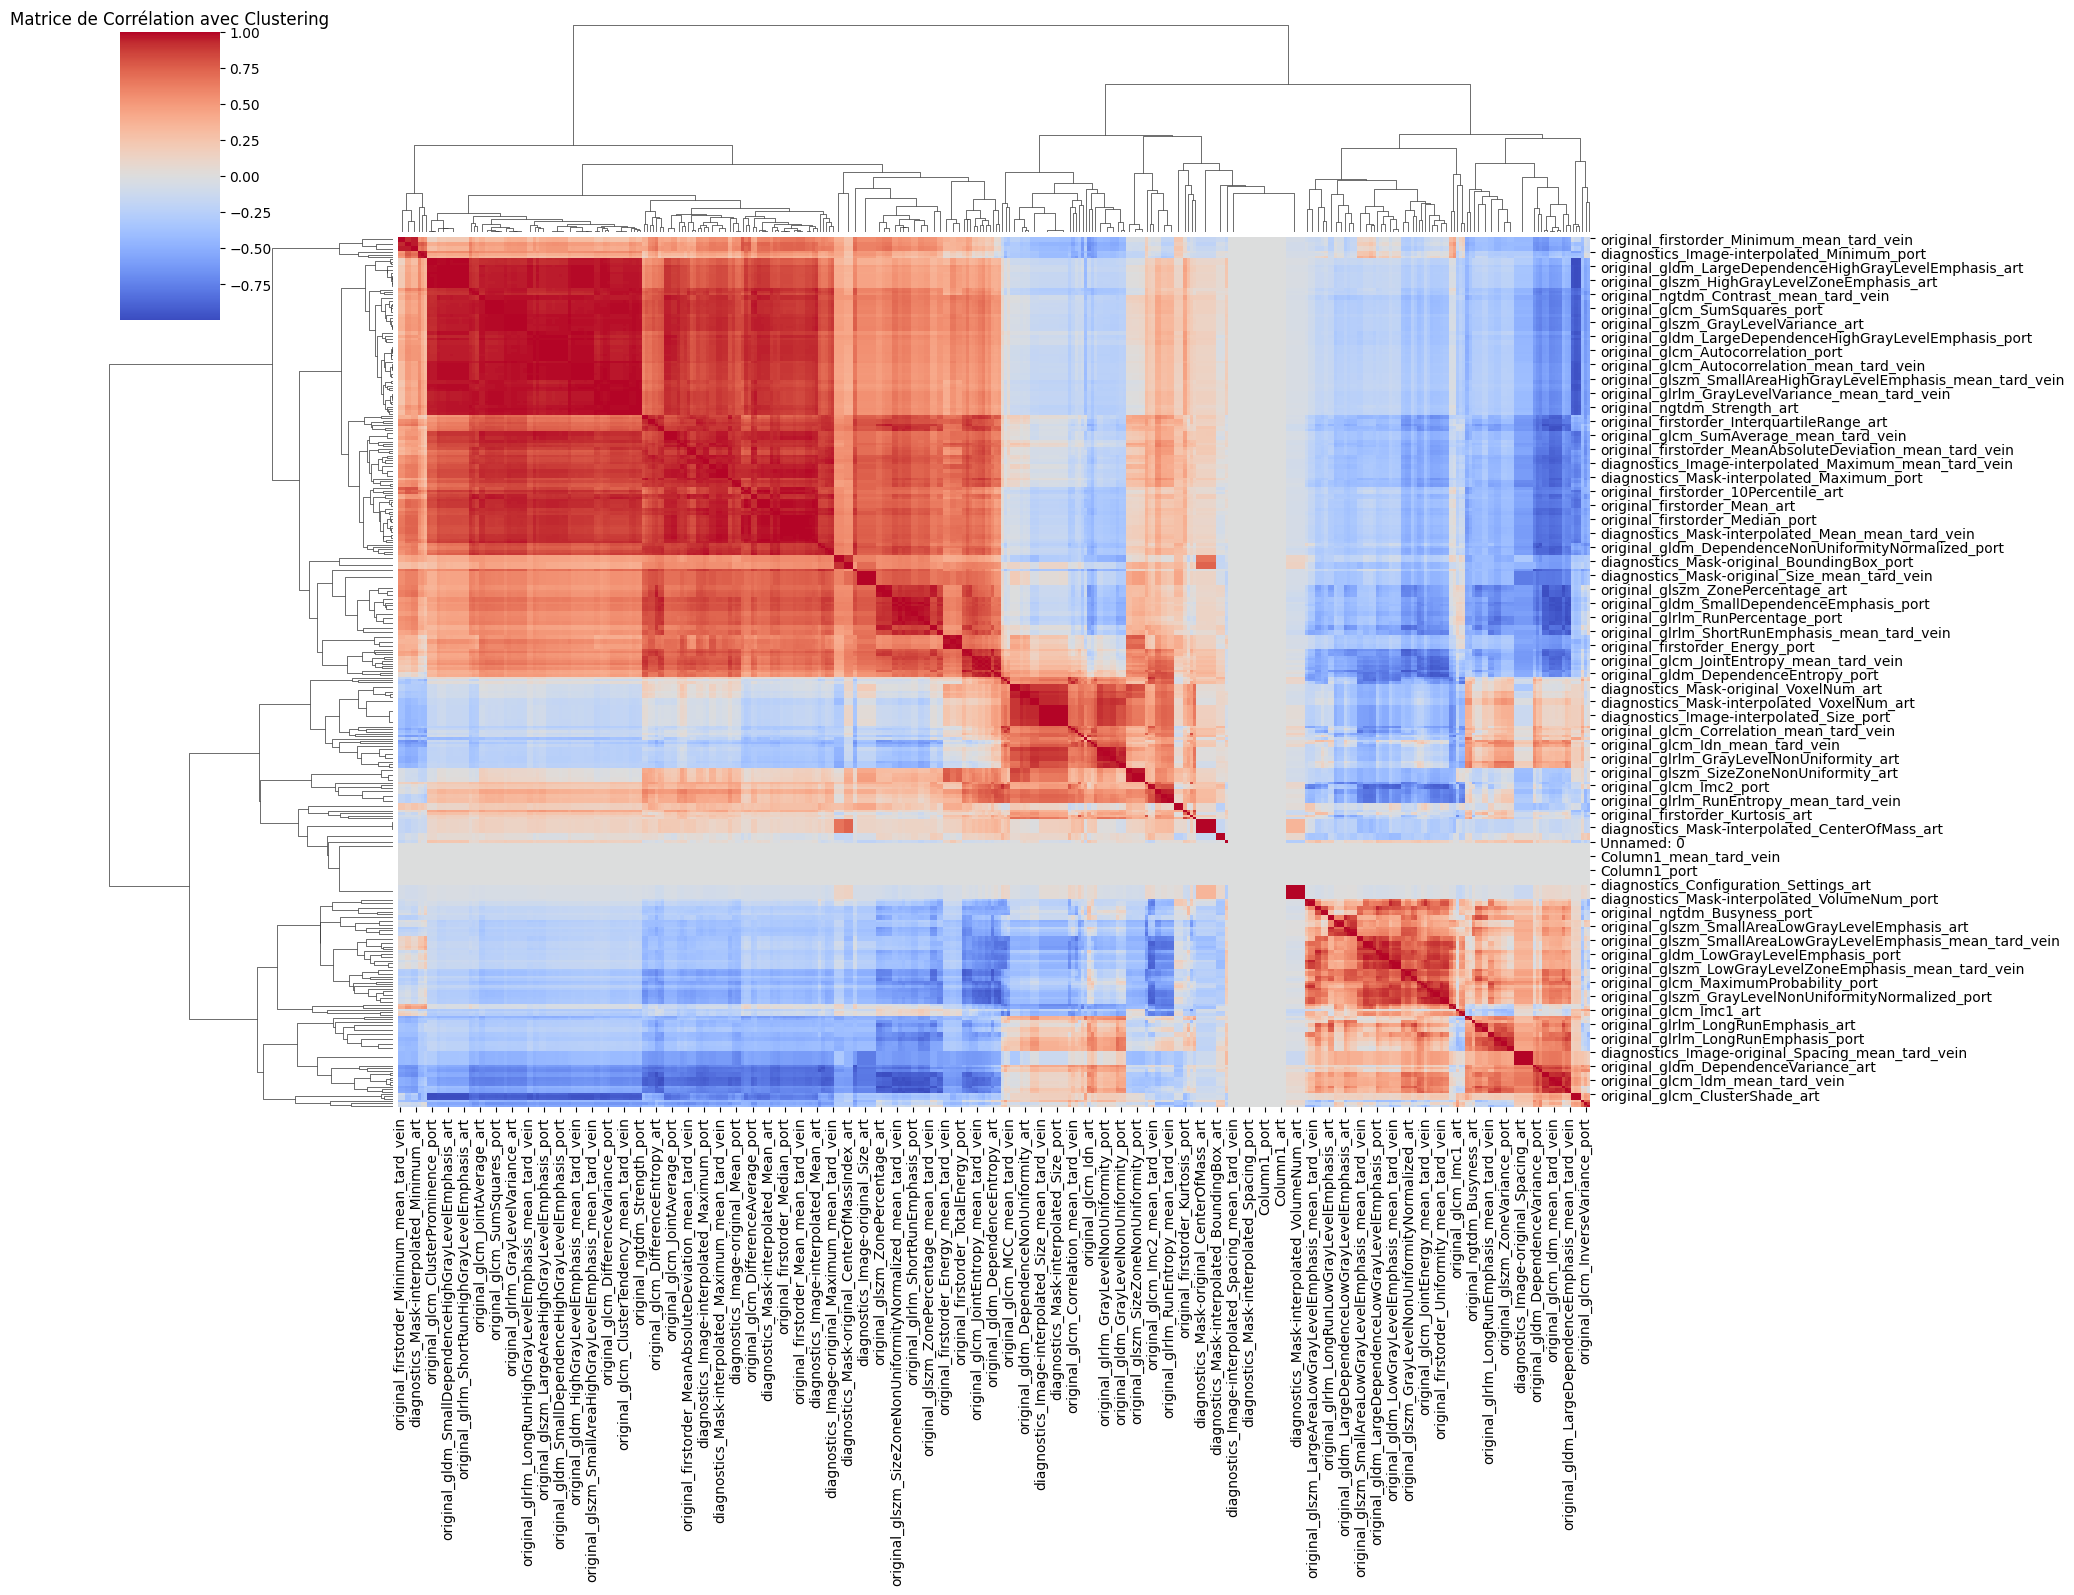

In [3]:
df_numeric = df_global.select_dtypes(include=[float, int]).iloc[:,:-2]
correlation_matrix = df_numeric.corr()

# Replace NaN and infinite values with zeros
correlation_matrix = correlation_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)

# Filter to display only correlations above a certain threshold
threshold = 0.8
high_corr_var = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]
filtered_corr_matrix = high_corr_var.dropna(axis=0, how='all').dropna(axis=1, how='all')

# # Plot the filtered heatmap
# plt.figure(figsize=(15, 12))
# sns.heatmap(filtered_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
# plt.title('Filtered Correlation Matrix (Threshold = 0.8)')
# plt.show()

# Plot the clustered heatmap
plt.figure(figsize=(20, 16))
sns.clustermap(correlation_matrix, annot=False, cmap='coolwarm', figsize=(20, 16))
plt.title('Matrice de Corrélation avec Clustering')
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/env_python_ete3/lib/python3.11/site-packages/sklearn/feature_selection/_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


Selected features after variance threshold:
Index(['Unnamed: 0', 'slice_num_art', 'original_firstorder_10Percentile_art',
       'original_firstorder_90Percentile_art',
       'original_firstorder_Energy_art', 'original_firstorder_Entropy_art',
       'original_firstorder_InterquartileRange_art',
       'original_firstorder_Kurtosis_art', 'original_firstorder_Maximum_art',
       'original_firstorder_MeanAbsoluteDeviation_art',
       ...
       'original_glszm_LargeAreaEmphasis_mean_tard_vein',
       'original_glszm_LargeAreaHighGrayLevelEmphasis_mean_tard_vein',
       'original_glszm_LargeAreaLowGrayLevelEmphasis_mean_tard_vein',
       'original_glszm_SizeZoneNonUniformity_mean_tard_vein',
       'original_glszm_SmallAreaHighGrayLevelEmphasis_mean_tard_vein',
       'original_glszm_ZoneEntropy_mean_tard_vein',
       'original_glszm_ZoneVariance_mean_tard_vein',
       'original_ngtdm_Busyness_mean_tard_vein',
       'original_ngtdm_Coarseness_mean_tard_vein',
       'original_ngt

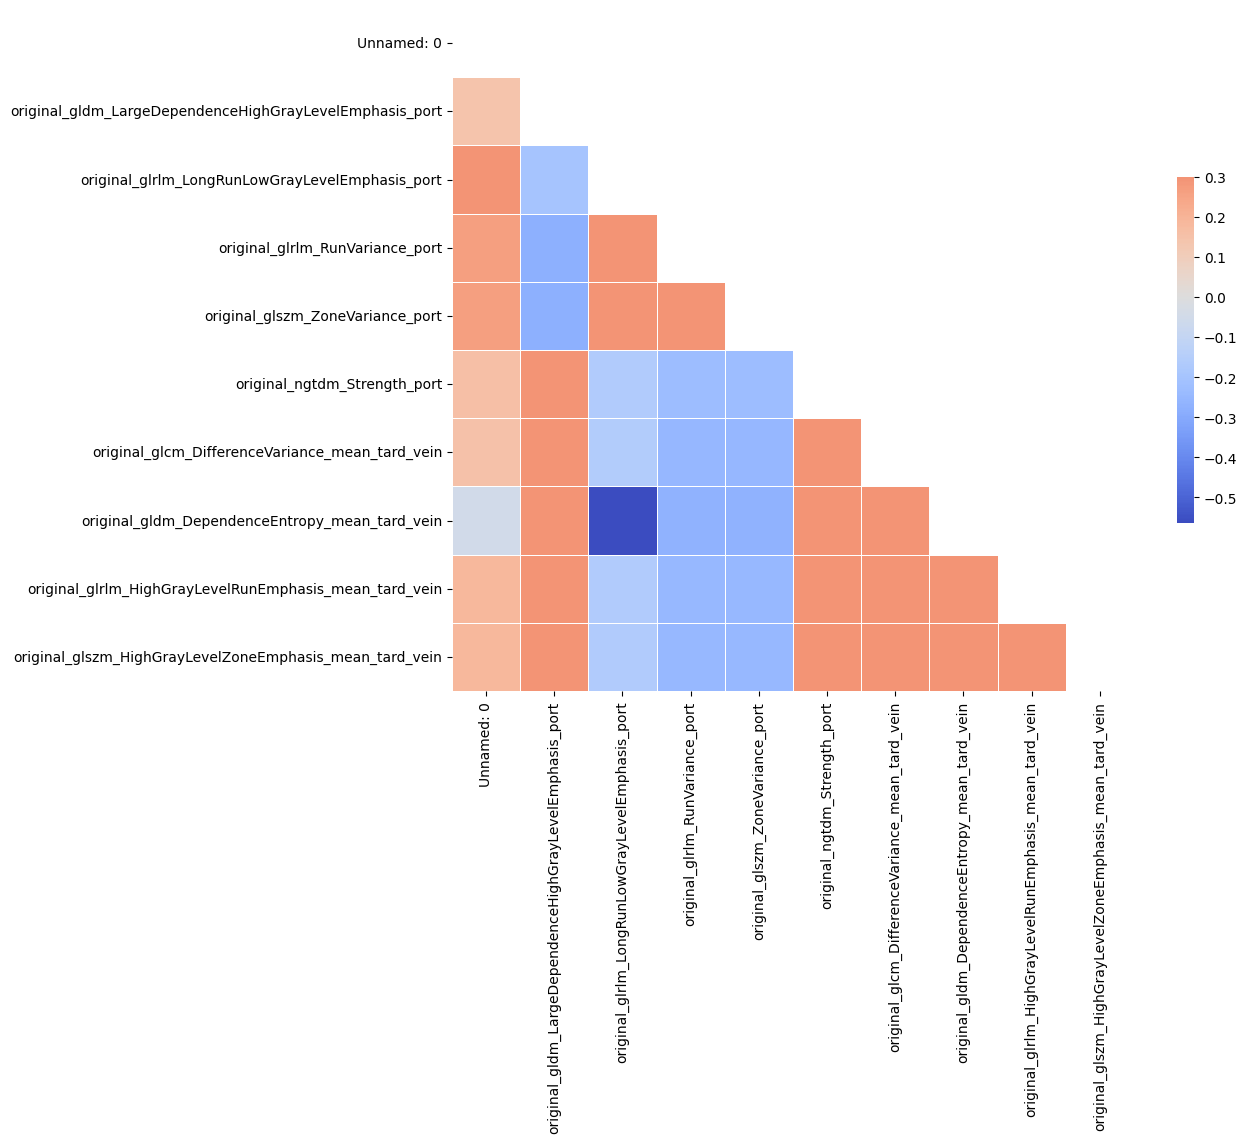

Features after Variance Threshold: Index(['Unnamed: 0', 'slice_num_art', 'original_firstorder_10Percentile_art',
       'original_firstorder_90Percentile_art',
       'original_firstorder_Energy_art', 'original_firstorder_Entropy_art',
       'original_firstorder_InterquartileRange_art',
       'original_firstorder_Kurtosis_art', 'original_firstorder_Maximum_art',
       'original_firstorder_MeanAbsoluteDeviation_art',
       ...
       'original_glszm_LargeAreaEmphasis_mean_tard_vein',
       'original_glszm_LargeAreaHighGrayLevelEmphasis_mean_tard_vein',
       'original_glszm_LargeAreaLowGrayLevelEmphasis_mean_tard_vein',
       'original_glszm_SizeZoneNonUniformity_mean_tard_vein',
       'original_glszm_SmallAreaHighGrayLevelEmphasis_mean_tard_vein',
       'original_glszm_ZoneEntropy_mean_tard_vein',
       'original_glszm_ZoneVariance_mean_tard_vein',
       'original_ngtdm_Busyness_mean_tard_vein',
       'original_ngtdm_Coarseness_mean_tard_vein',
       'original_ngtdm_Comple

In [4]:
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.ensemble import RandomForestClassifier

# Set classe_name as the target variable
target = df_global['classe_name']


# 1. Variance Threshold
selector = VarianceThreshold(threshold=0.1)
df_reduced = selector.fit_transform(df_numeric)
selected_features = df_numeric.columns[selector.get_support(indices=True)]
df_reduced = pd.DataFrame(df_reduced, columns=selected_features)
print("Selected features after variance threshold:")
print(selected_features)

# Store features after variance threshold
features_after_variance_threshold = selected_features

# 2. Model-Based Selection (RFE)
model = RandomForestClassifier()
rfe = RFE(estimator=model, n_features_to_select=10)
fit = rfe.fit(df_reduced, target)
selected_features = df_reduced.columns[fit.support_]
df_reduced = df_reduced[selected_features]
print("Selected features after RFE:")
print(selected_features)

# Store features after RFE
features_after_rfe = selected_features

# 3. Correlation Analysis
corr_matrix = df_reduced.corr()
high_corr_vars = np.where(np.abs(corr_matrix) > 0.8)
high_corr_vars = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_vars) if x != y and x < y]
print("Highly correlated variables (above threshold):")
print(high_corr_vars)

# Dropping one of each pair of highly correlated features
to_drop = set([var[1] for var in high_corr_vars])
df_reduced = df_reduced.drop(columns=to_drop)
print("Final reduced DataFrame:")
print(df_reduced.head())

# Store final features after correlation analysis
final_selected_features = df_reduced.columns

# Visualize the final correlation matrix
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# Output the most important features after each step
print("Features after Variance Threshold:", features_after_variance_threshold)
print("Features after RFE:", features_after_rfe)
print("Final selected features after Correlation Analysis:",final_selected_features)